### S'24 795/895 DL Fundamentals Final Project

**Important**: Rename the notebook with the UID of one of the team members as the prefix, such as jdoe001_xxxxxxx.ipynb.

**Important**: Contributer:Ashish Verma

#### Description
The task of the project is to implement CIFAR10 classification using LeNet. The second task is to use transfer learning to adapt the LeNet model trained on CIFAR10 data to STL-10.

#### Background:
LeNet is one of the *old* CNN models. Its structure can be described as: CONV-Pooling-CONV-Pooling-FC-FC. Below is a pictorial description:

![Screenshot 2024-03-20 at 1.48.02 PM.png](attachment:aa307695-8043-4875-9252-50ebd72643fd.png)

Both CIFAR10 and STL-10 are included in Torchvision. More details are at https://pytorch.org/vision/stable/datasets.html
#### Specific Requirements
1. You are required to implement it in PyTorch
2. You are required to use Dropout layers
3. You are required to use GPU.
4. You can use either colab or ODU HPC resources. It will take some time to train the model, hence I **strongly** suggest you start early.
5. You should implement it from scratch (Hint: there aren't too many examples of using LeNet for CIFAR10, so you have to write it yourself)
6. It has been reported that LeNet can achieve testing accuracy of ~65% for CIFAR10. I will accept any results with accuracy > 58% (If it's < 50%, it's acutally worse than a coin toss!)
7. You probably have to do some hyperparameter tuning to get there.
8. After the model is trained, you are required to use transfer learning method to adapt the model to STL-10 dataset. Retrain the model and achieve as good accuracy as possible.

#### Grading
1. You should implement everything in a single jupyter notebook and submit it before the deadline.
2. I recently aquired a desktop server with a beefy GPU. I **will** run your code to verify the output is correct, besides reading your pytorch code.  If your code won't run to completion, points will be deducted depending on where the failure is (the earlier the failure, the more points will be deducted).

## **Importing Pytorch Libraries**

In [111]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import gc
import warnings
warnings.filterwarnings('ignore')

## **Initializing GPUs**

In [112]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Data Augmentation and Transformations**

In [113]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##  **Data from Torchvision**

In [114]:
path = '/tmp'

train_ds = datasets.CIFAR10(root=path,
                            train=True,
                            transform=transform,
                            download=True
                           )

test_ds = datasets.CIFAR10(root=path,
                           train=False,
                           transform=transform
                           )

labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()

Files already downloaded and verified


## **Image Visualization**

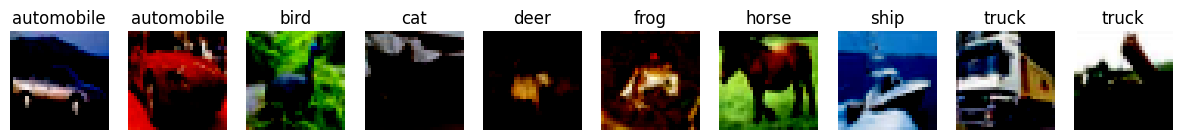

In [115]:
first_10_samples = sorted([train_ds[i] for i in range(10)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,11):
    img = first_10_samples[i-1][0].permute(1,2,0)
    label = labels[first_10_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **Class Config**

In [116]:
class Config:
    lr=1e-3
    epochs=15
    optim=torch.optim.Adam
    batch_size=64

## **DataLoaders**

In [117]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)

## **The LeNET Model**

In [118]:
class LeNet(nn.Module):

    def __init__(self, in_features=3, num_classes=10):
        super(LeNet, self).__init__()

        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                   out_channels=6,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2),
                                         nn.Dropout(0.2),
                                         nn.Conv2d(in_channels=6,
                                                   out_channels=16,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2)
                                        )

        self.linear_block = nn.Sequential( nn.Linear(400, 120),
                                           nn.ReLU(),
                                           nn.Linear(120,84),
                                           nn.ReLU(),
                                           nn.Linear(84,10)
                                         )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [119]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## **Training**

In [120]:
class Trainer:
    def __init__(self, model, dataloaders, device):
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim = Config.optim(self.model.parameters(), lr = Config.lr)
        self.device = device

    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)

    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.train_loader:

            self.optim.zero_grad()

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)

        return train_loss, train_acc

    @torch.no_grad()
    def valid_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.valid_loader:

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)

        return valid_loss, valid_acc


    def fit(self):
        print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")
        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []

        for epoch in range(Config.epochs):

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            self.model.eval()

            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            print(f"------EPOCH {epoch+1}/{Config.epochs}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")

            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()


        return (train_losses, train_accs), (valid_losses, valid_accs)

In [121]:
trainer = Trainer(model, (train_dataloader, valid_dataloader), device)

(train_losses, train_accs), (valid_losses, valid_accs) = trainer.fit()

Model is using cuda
------EPOCH 1/15------
Training: LOSS: 1.6851 | ACCURACY: 0.3809
Validation: LOSS: 1.5252 | ACCURACY: 0.4348


------EPOCH 2/15------
Training: LOSS: 1.4111 | ACCURACY: 0.4882
Validation: LOSS: 1.3301 | ACCURACY: 0.5171


------EPOCH 3/15------
Training: LOSS: 1.2957 | ACCURACY: 0.5346
Validation: LOSS: 1.2511 | ACCURACY: 0.5459


------EPOCH 4/15------
Training: LOSS: 1.2210 | ACCURACY: 0.5641
Validation: LOSS: 1.1859 | ACCURACY: 0.5721


------EPOCH 5/15------
Training: LOSS: 1.1668 | ACCURACY: 0.5847
Validation: LOSS: 1.1644 | ACCURACY: 0.5884


------EPOCH 6/15------
Training: LOSS: 1.1283 | ACCURACY: 0.5997
Validation: LOSS: 1.1244 | ACCURACY: 0.5976


------EPOCH 7/15------
Training: LOSS: 1.0961 | ACCURACY: 0.6100
Validation: LOSS: 1.1275 | ACCURACY: 0.5985


------EPOCH 8/15------
Training: LOSS: 1.0670 | ACCURACY: 0.6219
Validation: LOSS: 1.0949 | ACCURACY: 0.6103


------EPOCH 9/15------
Training: LOSS: 1.0347 | ACCURACY: 0.6339
Validation: LOSS: 1.0624 | 

## **Plot Losses**

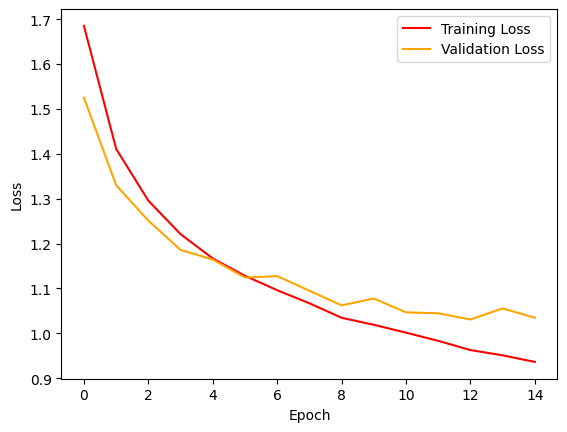

In [122]:
plt.plot(train_losses, color='red', label='Training Loss')
plt.plot(valid_losses, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Plot Accuracy**

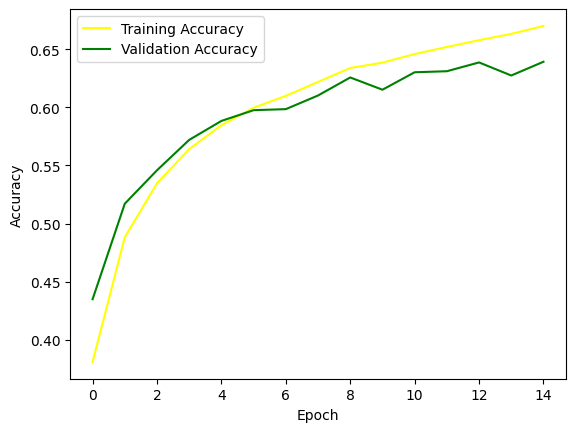

In [123]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Save Model**

In [124]:
## save model for later use
torch.save(model.state_dict(), './lenet_cifar10.pt')

In [125]:
!ls -al *.pt

-rw-r--r-- 1 root root 252108 Apr 11 19:22 lenet_cifar10.pt
-rw-r--r-- 1 root root 252192 Apr 11 18:01 lenet_tranfer_stl10.pt


# **Load Model**

In [126]:
model.load_state_dict(torch.load('./lenet_cifar10.pt'))
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_block.0.weight 	 torch.Size([6, 3, 5, 5])
conv_block.0.bias 	 torch.Size([6])
conv_block.4.weight 	 torch.Size([16, 6, 5, 5])
conv_block.4.bias 	 torch.Size([16])
linear_block.0.weight 	 torch.Size([120, 400])
linear_block.0.bias 	 torch.Size([120])
linear_block.2.weight 	 torch.Size([84, 120])
linear_block.2.bias 	 torch.Size([84])
linear_block.4.weight 	 torch.Size([10, 84])
linear_block.4.bias 	 torch.Size([10])


# **Data Transformation on STL-10**

In [127]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# **Transfer Learning on STL-10**

In [128]:
train_ds_stl = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_ds_stl = datasets.STL10(root='./data', split='test', download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


# **STL-10 Image Visualization**

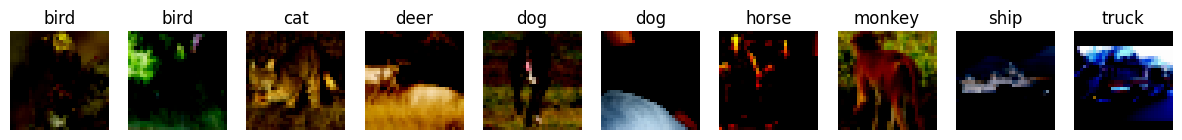

In [129]:
first_10_samples = sorted([train_ds_stl[i] for i in range(10)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,11):
    img = first_10_samples[i-1][0].permute(1,2,0)
    label = train_ds_stl.classes[first_10_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **STL-10 DataLoader**

In [130]:
train_dataloader_stl = torch.utils.data.DataLoader(train_ds_stl, batch_size=64, shuffle=True, num_workers=2)
valid_dataloader_stl = torch.utils.data.DataLoader(test_ds_stl, batch_size=64, shuffle=True, num_workers=2)

# **Create object for STL-10**

In [131]:
model_stl = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# **Load CIFAR-10 for STL-10**

In [132]:
# Load the weights from the trained CIFAR-10 model to the STL-10 model
model_stl.load_state_dict(model.state_dict())

<All keys matched successfully>

# **Train the STL-10 model**

In [133]:
class Trainer_STL:
    def __init__(self, model, dataloaders, device):

        self.config = {
            'lr':1e-4,
            'epochs': 100
        }

        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        #self.optim = torch.optim.Adam(self.model.parameters(), lr = self.config['lr'])
        self.optim = torch.optim.SGD(self.model.parameters(), lr = self.config['lr'],momentum=0.9)
        self.device = device

    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)

    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.train_loader:

            self.optim.zero_grad()

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)

        return train_loss, train_acc

    @torch.no_grad()
    def valid_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.valid_loader:

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)

        return valid_loss, valid_acc


    def fit(self):

        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []

        for epoch in range(self.config['epochs']):

            print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            self.model.eval()

            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            print(f"------EPOCH {epoch+1}/{self.config['epochs']}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")

            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()


        return (train_losses, train_accs), (valid_losses, valid_accs)

In [134]:
trainer_stl = Trainer_STL(model_stl, (train_dataloader_stl, valid_dataloader_stl), device)
(train_losses_stl, train_accs_stl), (valid_losses_stl, valid_accs_stl) = trainer_stl.fit()

Model is using cuda
------EPOCH 1/100------
Training: LOSS: 2.9633 | ACCURACY: 0.3089
Validation: LOSS: 2.6110 | ACCURACY: 0.3169


Model is using cuda
------EPOCH 2/100------
Training: LOSS: 2.4532 | ACCURACY: 0.3214
Validation: LOSS: 2.3192 | ACCURACY: 0.3164


Model is using cuda
------EPOCH 3/100------
Training: LOSS: 2.2386 | ACCURACY: 0.3240
Validation: LOSS: 2.1750 | ACCURACY: 0.3222


Model is using cuda
------EPOCH 4/100------
Training: LOSS: 2.1101 | ACCURACY: 0.3273
Validation: LOSS: 2.0727 | ACCURACY: 0.3285


Model is using cuda
------EPOCH 5/100------
Training: LOSS: 2.0268 | ACCURACY: 0.3356
Validation: LOSS: 2.0026 | ACCURACY: 0.3321


Model is using cuda
------EPOCH 6/100------
Training: LOSS: 1.9771 | ACCURACY: 0.3352
Validation: LOSS: 1.9451 | ACCURACY: 0.3351


Model is using cuda
------EPOCH 7/100------
Training: LOSS: 1.9285 | ACCURACY: 0.3430
Validation: LOSS: 1.9005 | ACCURACY: 0.3419


Model is using cuda
------EPOCH 8/100------
Training: LOSS: 1.8596 | ACCURAC

# **Plot STL Losses**

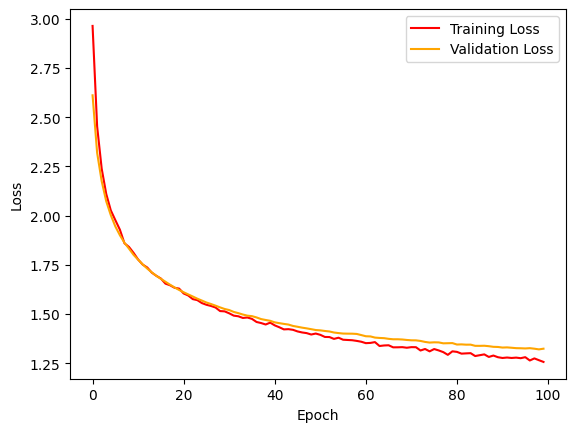

In [135]:
plt.plot(train_losses_stl, color='red', label='Training Loss')
plt.plot(valid_losses_stl, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Plot STL Accuracies**

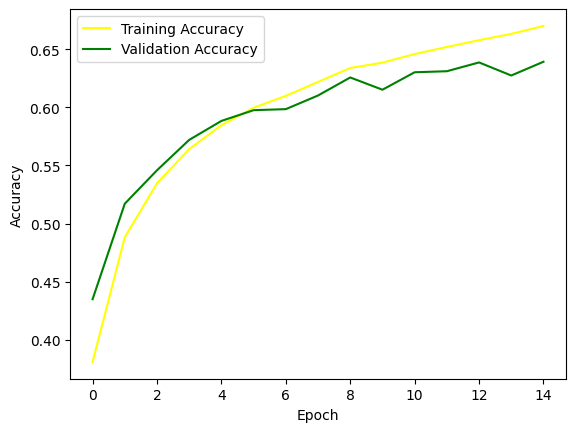

In [136]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [137]:
## save model for later use
torch.save(model_stl.state_dict(), './lenet_tranfer_stl10.pt')

# **Inception3 Transfer Learning on STL-10**

In [138]:
# Define transformation for training and validation data
transform = transforms.Compose([
    transforms.Resize(299),  # Inception-v3 input size
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# **Load the STL-10 Dataset**

In [139]:
# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)
class_names = image_datasets['train'].classes

Files already downloaded and verified
Files already downloaded and verified


In [140]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# **Modify the InceptionV3 Model**

In [141]:
# Load pre-trained Inception-v3 model
inception_v3 = models.inception_v3(pretrained=True)

# Replace the top classification layer
num_classes = 10  # Number of classes in STL-10
num_features = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_features, num_classes)


# **Define Loss Function and Optimizer**

In [142]:
# Optionally freeze layers
for param in inception_v3.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


# **Train the Model**

In [143]:
!pip install torchmetrics --quiet

In [144]:
!pip install lightning --quiet

In [145]:
import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Inception-v3 model
inception_v3 = models.inception_v3(pretrained=True)


batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

train_dataset = datasets.STL10(root="./data", split='train',transform=train_transform, download=True)
val_dataset = datasets.STL10(root="./data", split='test', transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = val_loader



Files already downloaded and verified
Files already downloaded and verified


In [146]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = models.inception_v3(weights="IMAGENET1K_V1")
#         for param in self.model.parameters():
#             param.requires_grad = False
        self.model.fc = nn.Linear(2048, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).logits
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

In [1]:
num_classes = 10
model = LitModel(num_classes=num_classes)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min")
trainer = pl.Trainer(max_epochs=20, enable_progress_bar=True, logger=logger, callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)

NameError: name 'LitModel' is not defined